# Read deviation data

There are two kinds of data in the `dev` files:

- **Deviation survey**, as measured in the well. This gives MD, Inclination, and Azimuth (measured from both true north (the north pole) and grid north (the direction of the northings in this projection).
- **Position log**, as computed from the deviation survey by whatever algorithm was preferred (it is not reported in the file.

Let's try to do several things:

- Get *position* data into a `pandas.DataFrame`
- Get *position* data into a `numpy.ndarray`
- Read LAS with `welly` and add *position* data
- Read LAS with `welly` and add *deviation* data and all the other data from the `dev` file (KB, (x, y), etc.)

---

There is not a lot of info in the LAS header, not even anything about the vertical datum. This is... a bit sad.

In [19]:
!head -55 ../data/NAM/Well_data/Groningen_field/01_Cluster_Wells/Eemskanaal/EKL-__1.las

The `dev` file has all the good stuff:

In [20]:
!head -20 ../data/NAM/Well_data/Groningen_field/01_Cluster_Wells/Eemskanaal/EKL-__1.dev

---

## Get position data into `pandas`

In [21]:
dev_file = "../data/NAM/Well_data/Groningen_field/01_Cluster_Wells/Eemskanaal/EKL-__1.dev"

In [22]:
import pandas as pd

names = "MD X Y Z TVD DX DY AZIM_TN INCL DLS AZIM_GN".split()

df = pd.read_csv(dev_file, sep=' ', skiprows=17, names=names, skipinitialspace=True)

df.head()

,MD,X,Y,Z,TVD,DX,DY,AZIM_TN,INCL,DLS,AZIM_GN
0,0.0,241602.09086,584344.22236,5.580000,0.000000,0.000000,0.000000,296.032022,0.150000,0.000000,294.999990
1,25.0,241602.03154,584344.25002,-19.419886,24.999886,-0.059318,0.027660,283.434353,0.251411,0.132000,282.402321
2,50.0,241601.92440,584344.27358,-44.419624,49.999624,-0.166456,0.051221,244.996282,0.107777,0.215918,243.964250
3,75.0,241601.88215,584344.25294,-69.419556,74.999556,-0.208710,0.030579,254.449254,0.028625,0.095615,253.417222
4,100.0,241601.87018,584344.24938,-94.419525,99.999525,-0.220681,0.027015,305.087814,0.089898,0.090095,304.055782


---

## Get position data into `numpy`

In [23]:
import numpy as np

position = np.genfromtxt(dev_file, skip_header=17)
position.shape

(117, 11)

---

## Add position log to `welly.Well` object directly

In [24]:
from welly import Well

las_file = "../data/NAM/Well_data/Groningen_field/01_Cluster_Wells/Eemskanaal/EKL-__1.las"
w = Well.from_las(las_file)

/home/matt/anaconda3/envs/py38/lib/python3.8/site-packages/welly/well.py:193: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)


In [25]:
w.location

Location({'td': None, 'position': None, 'crs': CRS({}), 'location': '', 'province': '', 'api': '', 'deviation': None})

In [26]:
w.location.position = position[:, [1, 2, 3]]

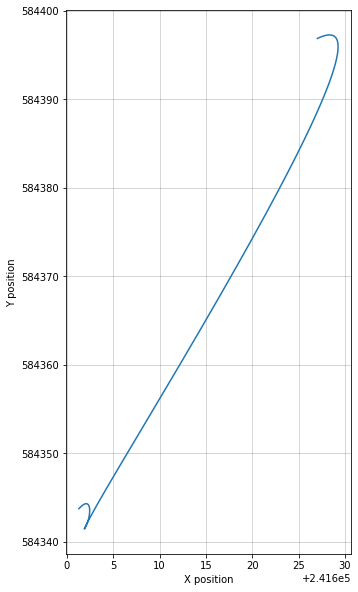

In [27]:
w.location.plot_plan()

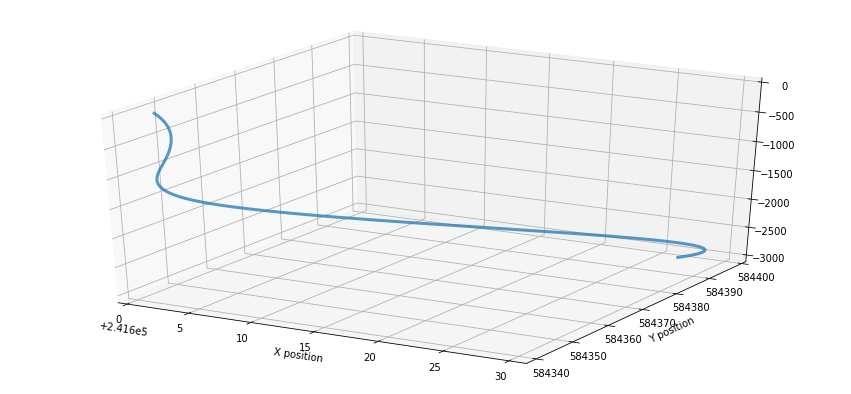

In [28]:
w.location.plot_3d()

Note that adding the position log does not give you a deviation survey, because the latter is typically "canonical" data and perhaps should not come from the position log (which is usually computed from the deviation).

In [29]:
w.location.deviation

---

## Computing position from the deviation survey with `welly`

We need the KB of the well.

    # WELL TRACE FROM PETREL 
    # WELL NAME:              EKL-  1
    # DEFINITIVE SURVEY:      Explicit survey 1
    # WELL HEAD X-COORDINATE: 241602.09085816 (m)
    # WELL HEAD Y-COORDINATE: 584344.22236241 (m)
    # WELL DATUM (KB, Kelly bushing, from MSL): 5.57999992 (m)
    # WELL TYPE:              UNDEFINED
    # MD AND TVD ARE REFERENCED (=0) AT WELL DATUM AND INCREASE DOWNWARDS
    # ANGLES ARE GIVEN IN DEGREES
    # XYZ TRACE IS GIVEN IN COORDINATE SYSTEM Amersfoort / RD New [1672_28992] (NL Onshore) [Petrel,700049]
    # AZIM_TN: azimuth in True North 
    # AZIM_GN: azimuth in Grid North 
    # DX DY ARE GIVEN IN GRID NORTH IN m-UNITS
    # DEPTH (Z, tvd_z) GIVEN IN m-UNITS
    #=============================================

As before, let's make a new well — initially it will not have a position log.

In [30]:
x = Well.from_las(las_file)
x.location

Location({'td': None, 'position': None, 'crs': CRS({}), 'location': '', 'province': '', 'api': '', 'deviation': None})

**This requires `welly` version 0.4.8 or later. Do this to get it, or to upgrade:**

    pip install --upgrade welly
    
**If you can't or won't upgrade, you can call `w.location.add_deviation()` and pass it the appropriate columns (e.g. `[0, 8, 10]` from the data you loaded as a DataFrame or ndarray (above).**

You can create a `Location` object from a Petrel `.dev` file. By default this will *not* recompute the position log (X, Y, TVDSS) from the deviation survey (MD, INCL, AZIM), but you can force it to with `recalc=True`.

In [31]:
from welly import Location

x.location = Location.from_petrel(dev_file)  # Use the position data in the file.
x.location

Location({'td': None, 'position': array([[ 1.84000237e-06, -2.41002999e-06,  3.70000031e-09],
       [-5.93181600e-02,  2.76575900e-02, -2.49998856e+01],
       [-1.66458160e-01,  5.12175900e-02, -4.99996242e+01],
       [-2.08708160e-01,  3.05775900e-02, -7.49995556e+01],
       [-2.20678160e-01,  2.70175900e-02, -9.99995251e+01],
       [-2.53178160e-01,  4.89775899e-02, -1.24999495e+02],
       [-2.67408160e-01,  7.54075899e-02, -1.49999464e+02],
       [-2.57838160e-01,  9.92375900e-02, -1.74999449e+02],
       [-2.35518160e-01,  9.45575900e-02, -1.99999434e+02],
       [-2.12308160e-01,  4.76875900e-02, -2.24999373e+02],
       [-2.00628160e-01, -4.69724101e-02, -2.49999174e+02],
       [-1.90518160e-01, -1.59772410e-01, -2.74998945e+02],
       [-1.76888160e-01, -2.83302410e-01, -2.99998640e+02],
       [-1.51258160e-01, -4.26542410e-01, -3.24998213e+02],
       [-1.34078160e-01, -5.65582410e-01, -3.49997816e+02],
       [-1.38428160e-01, -7.02942410e-01, -3.74997450e+02],
      

In [32]:
x.location = Location.from_petrel(dev_file, recalc=True)
x.location

Location({'td': None, 'position': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.32281109e-02,  2.56103780e-02,  2.49998445e+01],
       [-1.57924564e-01,  2.70699103e-02,  4.99997226e+01],
       [-1.85036968e-01,  1.49668686e-02,  7.49997030e+01],
       [-2.07271149e-01,  2.41675973e-02,  9.99996896e+01],
       [-2.30634796e-01,  4.83641971e-02,  1.24999666e+02],
       [-2.32966026e-01,  7.34948864e-02,  1.49999653e+02],
       [-2.17021041e-01,  8.30711306e-02,  1.74999644e+02],
       [-1.94254135e-01,  5.72958047e-02,  1.99999618e+02],
       [-1.76810146e-01, -1.34701378e-02,  2.24999507e+02],
       [-1.65917167e-01, -1.17201751e-01,  2.49999289e+02],
       [-1.54046089e-01, -2.35364675e-01,  2.74999007e+02],
       [-1.34416340e-01, -3.68751953e-01,  2.99998642e+02],
       [-1.13013374e-01, -5.09893168e-01,  3.24998235e+02],
       [-1.06599054e-01, -6.48091533e-01,  3.49997851e+02],
       [-1.15597676e-01, -7.84908784e-01,  3.74997475e+02],
      

Now the well has a position log, computed from this deviation survey:

In [33]:
x.location.position

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.32281109e-02,  2.56103780e-02,  2.49998445e+01],
       [-1.57924564e-01,  2.70699103e-02,  4.99997226e+01],
       [-1.85036968e-01,  1.49668686e-02,  7.49997030e+01],
       [-2.07271149e-01,  2.41675973e-02,  9.99996896e+01],
       [-2.30634796e-01,  4.83641971e-02,  1.24999666e+02],
       [-2.32966026e-01,  7.34948864e-02,  1.49999653e+02],
       [-2.17021041e-01,  8.30711306e-02,  1.74999644e+02],
       [-1.94254135e-01,  5.72958047e-02,  1.99999618e+02],
       [-1.76810146e-01, -1.34701378e-02,  2.24999507e+02],
       [-1.65917167e-01, -1.17201751e-01,  2.49999289e+02],
       [-1.54046089e-01, -2.35364675e-01,  2.74999007e+02],
       [-1.34416340e-01, -3.68751953e-01,  2.99998642e+02],
       [-1.13013374e-01, -5.09893168e-01,  3.24998235e+02],
       [-1.06599054e-01, -6.48091533e-01,  3.49997851e+02],
       [-1.15597676e-01, -7.84908784e-01,  3.74997475e+02],
       [-1.34066527e-01, -9.17446467e-01

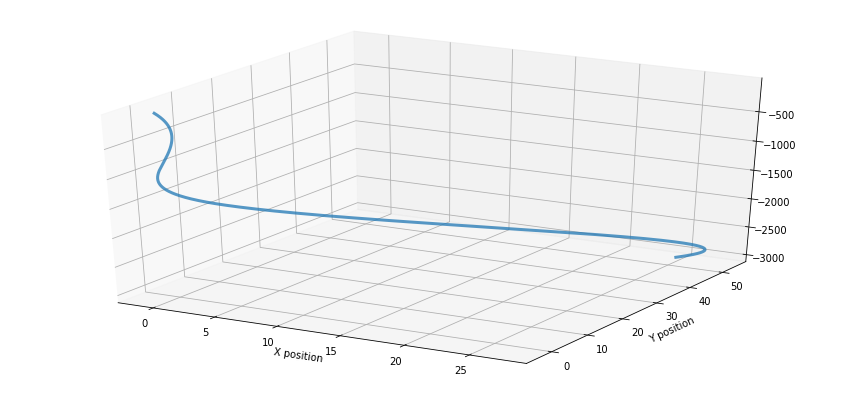

In [34]:
x.location.plot_3d()